## 引入残差快
定义残差块：创建一个ResidualBlock类，包含两个卷积层和一个跳跃连接（shortcut）。如果输入和输出通道数不同，通过1x1卷积调整维度。

编码器修改：在编码器的每个主要卷积层后添加一个残差块。例如，初始卷积后添加encoder_res1，然后进行下采样，再添加encoder_res2，依此类推。

解码器修改：同样，在解码器的每个反卷积层后添加一个残差块，如decoder_res1、decoder_res2等，以促进特征的传递和梯度的流动。

使用设备: cuda


Epoch 1/10: 100%|██████████| 1272/1272 [01:06<00:00, 19.13it/s]

Epoch 1, 平均训练损失: 1419.4014, 学习率: 0.001


验证集平均损失: 874.0053


Epoch 2/10: 100%|██████████| 1272/1272 [01:05<00:00, 19.43it/s]

Epoch 2, 平均训练损失: 755.3740, 学习率: 0.001


验证集平均损失: 689.0685


Epoch 3/10: 100%|██████████| 1272/1272 [01:08<00:00, 18.59it/s]

Epoch 3, 平均训练损失: 657.2744, 学习率: 0.001


验证集平均损失: 578.4082


Epoch 4/10: 100%|██████████| 1272/1272 [01:05<00:00, 19.46it/s]

Epoch 4, 平均训练损失: 538.1459, 学习率: 0.001


验证集平均损失: 522.4571


Epoch 5/10: 100%|██████████| 1272/1272 [01:08<00:00, 18.63it/s]

Epoch 5, 平均训练损失: 508.4676, 学习率: 0.001


验证集平均损失: 490.9021


Epoch 6/10: 100%|██████████| 1272/1272 [01:05<00:00, 19.48it/s]

Epoch 6, 平均训练损失: 482.7804, 学习率: 0.001


验证集平均损失: 472.4149


Epoch 7/10: 100%|██████████| 1272/1272 [01:06<00:00, 19.07it/s]

Epoch 7, 平均训练损失: 468.0740, 学习率: 0.001


验证集平均损失: 459.2017


Epoch 8/10: 100%|██████████| 1272/1272 [01:09<00:00, 18.34it/s]

Epoch 8, 平均训练损失: 463.6623, 学习率: 0.001


验证集平均损失: 460.4271


Epoch 9/10: 100%|██████████| 1272/1272 [01:14<00:00, 17.12it/s]

Epoch 9, 平均训练损失: 446.0562, 学习率: 0.001


验证集平均损失: 455.4881


Epoch 10/10: 100%|██████████| 1272/1272 [01:14<00:00, 17.06it/s]

Epoch 10, 平均训练损失: 470.4822, 学习率: 0.0001


验证集平均损失: 451.8892


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/root/miniconda3/envs/pytorc_test1/lib/python3

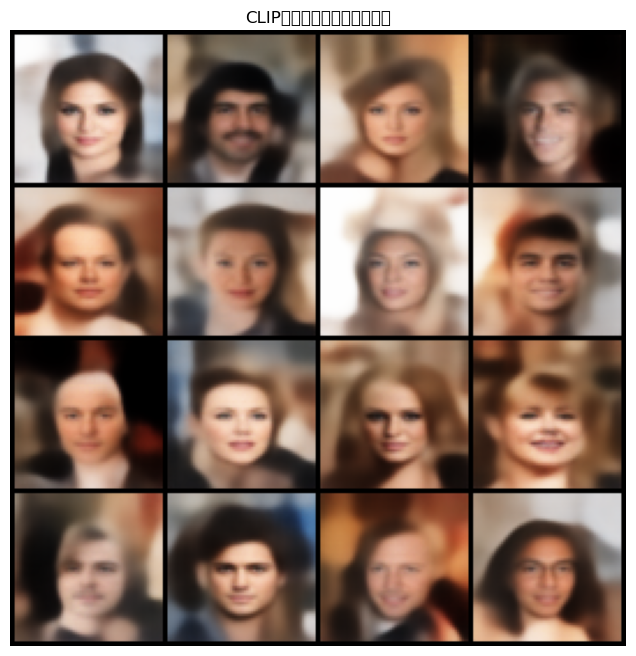

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

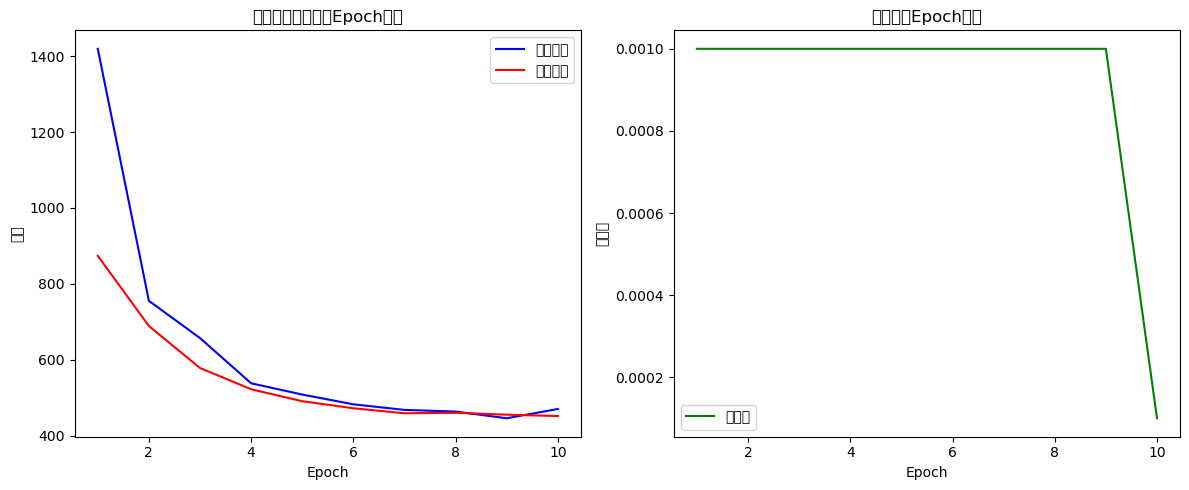

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

# 设置Matplotlib使用支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载CLIP模型
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# 文本提示词
TEXT_PROMPTS = [
    "A portrait of a young woman",
    "A realistic face with a smile",
    "A person with distinct facial features"
]

# 生成CLIP文本嵌入
def generate_text_embeddings(text_prompts):
    text_tokens = clip.tokenize(text_prompts).to(device)
    with torch.no_grad():
        text_embeddings = clip_model.encode_text(text_tokens)
    return text_embeddings.cpu()

CLIP_TEXT_EMBEDDINGS = generate_text_embeddings(TEXT_PROMPTS)

# CelebA数据集类
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, bbox_path, partition_path, 
                 transform=None, partition=0):
        self.img_dir = img_dir
        self.transform = transform

        attr_df = pd.read_csv(attr_path, sep=',', header=0)
        partition_df = pd.read_csv(partition_path, sep=',', header=0)
        attr_df = attr_df.merge(partition_df, on='image_id')
        self.attr_df = attr_df[attr_df['partition'] == partition]
        bbox_df = pd.read_csv(bbox_path, sep=',', header=0)
        self.attr_df = self.attr_df.merge(bbox_df, on='image_id')

    def __len__(self):
        return len(self.attr_df)

    def __getitem__(self, idx):
        img_name = self.attr_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        attrs = self.attr_df.iloc[idx, 1:41].values
        attrs = (attrs + 1) // 2
        attrs = attrs.astype(np.float32)
        if self.transform:
            image = self.transform(image)
        random_idx = random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)
        clip_embedding = CLIP_TEXT_EMBEDDINGS[random_idx]
        return image, attrs, clip_embedding

# 残差块定义
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

# ClipCVAE模型定义
class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器部分
        self.encoder_initial = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.encoder_res1 = ResidualBlock(64, 128)
        self.encoder_down1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.encoder_res2 = ResidualBlock(128, 256)
        self.encoder_down2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.encoder_res3 = ResidualBlock(256, 512)
        self.encoder_down3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器部分
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder_up0 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.decoder_res1 = ResidualBlock(512, 256)
        self.decoder_up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.decoder_res2 = ResidualBlock(256, 128)
        self.decoder_up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.decoder_res3 = ResidualBlock(128, 64)
        self.decoder_up3 = nn.Sequential(
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder_initial(x)
        x = self.encoder_res1(x)
        x = self.encoder_down1(x)
        x = self.encoder_res2(x)
        x = self.encoder_down2(x)
        x = self.encoder_res3(x)
        x = self.encoder_down3(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder_up0(x)
        x = self.decoder_res1(x)
        x = self.decoder_up1(x)
        x = self.decoder_res2(x)
        x = self.decoder_up2(x)
        x = self.decoder_res3(x)
        x = self.decoder_up3(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 修正归一化
])

# 数据集路径设置（请根据实际路径修改）
img_dir = '/root/autodl-tmp/celeba_datasets/img_align_celeba/img_align_celeba'
attr_path = '/root/autodl-tmp/celeba_datasets/list_attr_celeba.txt'
bbox_path = '/root/autodl-tmp/celeba_datasets/list_bbox_celeba.txt'
partition_path = '/root/autodl-tmp/celeba_datasets/list_eval_partition.txt'

# 创建训练集和验证集
train_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                              transform=transform, partition=0)
val_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                            transform=transform, partition=1)

# 数据加载器
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 初始化模型、损失函数和优化器
latent_dim = 128
cond_dim = 40
clip_dim = 512
model = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                 cond_dim=cond_dim, clip_dim=clip_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='sum')

# 定义损失函数
def loss_function(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KL

# 定义学习率调度器（可选）
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 训练模型
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50):
    # 记录损失
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': []
    }
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, attrs, clip_emb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
            data = data.to(device, non_blocking=True)
            attrs = attrs.to(device, non_blocking=True)
            clip_emb = clip_emb.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, attrs, clip_emb)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        # 更新学习率
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        history['learning_rate'].append(current_lr)
        print(f"Epoch {epoch}, 平均训练损失: {avg_train_loss:.4f}, 学习率: {current_lr}")
        
        # 验证集评估
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, attrs, clip_emb in val_loader:
                data = data.to(device, non_blocking=True)
                attrs = attrs.to(device, non_blocking=True)
                clip_emb = clip_emb.to(device, non_blocking=True)
                recon_batch, mu, logvar = model(data, attrs, clip_emb)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(avg_val_loss)
        print(f"验证集平均损失: {avg_val_loss:.4f}")
    
    return model, history

# 图像生成函数
def generate_images(model, attrs, text_prompts, device, num_images=16):
    """
    根据条件标签和文本提示生成图像
    """
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        attrs = attrs[:num_images].to(device)
        
        # 对于每个图像随机选择一个文本嵌入
        text_embeddings = torch.stack([
            CLIP_TEXT_EMBEDDINGS[random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)] 
            for _ in range(num_images)
        ]).to(device)
        
        generated = model.decode(z, attrs, text_embeddings)
        generated = generated.cpu()
        return generated

# 训练模型
trained_model, history = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=10)

# 保存模型
torch.save(trained_model.state_dict(), 'clip_cvae_celeba.pth')

# 生成图像示例
data_iter = iter(val_loader)
images, attrs, _ = next(data_iter)
sample_attrs = attrs[:16]

generated_images = generate_images(trained_model, sample_attrs, TEXT_PROMPTS, device, num_images=16)

# 可视化生成的图像
def show_images(images, title="Generated Images"):
    images = images * 0.5 + 0.5  # 反归一化
    grid = torchvision.utils.make_grid(images, nrow=4)
    np_grid = grid.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

show_images(generated_images, title="CLIP引导的条件生成人脸图像")

# 绘制损失曲线
def plot_loss(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12,5))
    
    # 绘制训练和验证损失
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='训练损失')
    plt.plot(epochs, history['val_loss'], 'r-', label='验证损失')
    plt.title('训练和验证损失随Epoch变化')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.legend()
    
    # 绘制学习率
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['learning_rate'], 'g-', label='学习率')
    plt.title('学习率随Epoch变化')
    plt.xlabel('Epoch')
    plt.ylabel('学习率')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_loss(history)


In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import clip
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

# 设置Matplotlib使用支持中文的字体
def set_chinese_font(font_path):
    """
    设置Matplotlib使用指定的中文字体。
    :param font_path: 字体文件的绝对路径
    """
    if not os.path.exists(font_path):
        raise FileNotFoundError(f"指定的字体文件不存在: {font_path}")

    # 添加字体到Matplotlib的字体管理器
    fm.fontManager.addfont(font_path)
    fm._rebuild()

    # 创建字体属性
    font_prop = fm.FontProperties(fname=font_path)
    font_name = font_prop.get_name()

    # 设置全局字体
    plt.rcParams['font.family'] = font_name
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    print(f"已设置Matplotlib使用字体: {font_name}")

# 指定你的中文字体路径
font_path = '/root/autodl-tmp/SimHei.ttf'  # 请根据实际路径修改

try:
    set_chinese_font(font_path)
except FileNotFoundError as e:
    print(e)
    print("请确保字体文件路径正确且字体已安装。")
    # 你也可以选择使用其他已安装的中文字体，例如 'Noto Sans CJK SC'
    # 例如:
    # font_path = '/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc'
    # set_chinese_font(font_path)

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载CLIP模型
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# 文本提示词
TEXT_PROMPTS = [
    "A portrait of a young woman",
    "A realistic face with a smile",
    "A person with distinct facial features"
]

# 生成CLIP文本嵌入（提前计算以避免重复计算）
def generate_text_embeddings(text_prompts):
    text_tokens = clip.tokenize(text_prompts).to(device)
    with torch.no_grad():
        text_embeddings = clip_model.encode_text(text_tokens)
    return text_embeddings.cpu()  # 移动到CPU

# 预先计算文本嵌入
CLIP_TEXT_EMBEDDINGS = generate_text_embeddings(TEXT_PROMPTS)

# CelebA数据集类
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, bbox_path, partition_path, 
                 transform=None, partition=0):
        """
        初始化数据集
        :param img_dir: 图像文件夹路径
        :param attr_path: 属性文件路径
        :param bbox_path: 边界框文件路径
        :param partition_path: 分区文件路径
        :param transform: 图像预处理
        :param partition: 使用的数据分区 (0: train, 1: val, 2: test)
        """
        self.img_dir = img_dir
        self.transform = transform

        # 读取属性文件
        attr_df = pd.read_csv(attr_path, sep=',', header=0)
        partition_df = pd.read_csv(partition_path, sep=',', header=0)
        
        # 合并属性文件和分区文件
        attr_df = attr_df.merge(partition_df, on='image_id')
        
        # 根据指定的分区进行筛选
        self.attr_df = attr_df[attr_df['partition'] == partition]
        
        # 读取边界框文件
        bbox_df = pd.read_csv(bbox_path, sep=',', header=0)
        
        # 合并边界框信息
        self.attr_df = self.attr_df.merge(bbox_df, on='image_id')

    def __len__(self):
        return len(self.attr_df)

    def __getitem__(self, idx):
        # 获取图像文件名
        img_name = self.attr_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        
        # 打开图像并转换为RGB
        image = Image.open(img_path).convert('RGB')
        
        # 获取属性标签 
        attrs = self.attr_df.iloc[idx, 1:41].values
        attrs = (attrs + 1) // 2  # 将-1转为0，1保持1
        attrs = attrs.astype(np.float32)
        
        # 应用图像预处理
        if self.transform:
            image = self.transform(image)
        
        # 随机选择一个CLIP文本嵌入
        random_idx = random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)
        clip_embedding = CLIP_TEXT_EMBEDDINGS[random_idx]
        
        return image, attrs, clip_embedding

# 残差块定义
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

# ClipCVAE模型定义
class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器部分
        self.encoder_initial = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.encoder_res1 = ResidualBlock(64, 128)
        self.encoder_down1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.encoder_res2 = ResidualBlock(128, 256)
        self.encoder_down2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.encoder_res3 = ResidualBlock(256, 512)
        self.encoder_down3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器部分
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder_up0 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.decoder_res1 = ResidualBlock(512, 256)
        self.decoder_up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.decoder_res2 = ResidualBlock(256, 128)
        self.decoder_up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.decoder_res3 = ResidualBlock(128, 64)
        self.decoder_up3 = nn.Sequential(
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        # 将条件标签、图像和CLIP嵌入拼接
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder_initial(x)
        x = self.encoder_res1(x)
        x = self.encoder_down1(x)
        x = self.encoder_res2(x)
        x = self.encoder_down2(x)
        x = self.encoder_res3(x)
        x = self.encoder_down3(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        # 将潜在变量、条件标签和CLIP嵌入拼接
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder_up0(x)
        x = self.decoder_res1(x)
        x = self.decoder_up1(x)
        x = self.decoder_res2(x)
        x = self.decoder_up2(x)
        x = self.decoder_res3(x)
        x = self.decoder_up3(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 修正归一化
])

# 数据集路径设置（请根据实际路径修改）
img_dir = '/root/autodl-tmp/celeba_datasets/img_align_celeba/img_align_celeba'
attr_path = '/root/autodl-tmp/celeba_datasets/list_attr_celeba.txt'
bbox_path = '/root/autodl-tmp/celeba_datasets/list_bbox_celeba.txt'
partition_path = '/root/autodl-tmp/celeba_datasets/list_eval_partition.txt'

# 创建训练集和验证集
train_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                              transform=transform, partition=0)
val_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                            transform=transform, partition=1)

# 数据加载器
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 初始化模型、损失函数和优化器
latent_dim = 128
cond_dim = 40
clip_dim = 512
model = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                 cond_dim=cond_dim, clip_dim=clip_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='sum')

# 定义损失函数
def loss_function(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KL

# 定义学习率调度器（可选）
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 训练模型
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50):
    # 记录损失
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': []
    }
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, attrs, clip_emb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
            data = data.to(device, non_blocking=True)
            attrs = attrs.to(device, non_blocking=True)
            clip_emb = clip_emb.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, attrs, clip_emb)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        # 更新学习率
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        history['learning_rate'].append(current_lr)
        print(f"Epoch {epoch}, 平均训练损失: {avg_train_loss:.4f}, 学习率: {current_lr}")
        
        # 验证集评估
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, attrs, clip_emb in val_loader:
                data = data.to(device, non_blocking=True)
                attrs = attrs.to(device, non_blocking=True)
                clip_emb = clip_emb.to(device, non_blocking=True)
                recon_batch, mu, logvar = model(data, attrs, clip_emb)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(avg_val_loss)
        print(f"验证集平均损失: {avg_val_loss:.4f}")
    
    return model, history

# 图像生成函数
def generate_images(model, attrs, text_prompts, device, num_images=16):
    """
    根据条件标签和文本提示生成图像
    """
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        attrs = attrs[:num_images].to(device)
        
        # 对于每个图像随机选择一个文本嵌入
        text_embeddings = torch.stack([
            CLIP_TEXT_EMBEDDINGS[random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)] 
            for _ in range(num_images)
        ]).to(device)
        
        generated = model.decode(z, attrs, text_embeddings)
        generated = generated.cpu()
        return generated

# 训练模型
trained_model, history = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=10)

# 保存模型
torch.save(trained_model.state_dict(), 'clip_cvae_celeba.pth')

# 生成图像示例
data_iter = iter(val_loader)
images, attrs, _ = next(data_iter)
sample_attrs = attrs[:16]

generated_images = generate_images(trained_model, sample_attrs, TEXT_PROMPTS, device, num_images=16)

# 可视化生成的图像
def show_images(images, title="Generated Images"):
    images = images * 0.5 + 0.5  # 反归一化
    grid = torchvision.utils.make_grid(images, nrow=4)
    np_grid = grid.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title, fontsize=16)  # 全局字体已设置
    plt.axis('off')
    plt.show()

def plot_loss(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12,5))
    
    # 绘制训练和验证损失
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='训练损失')
    plt.plot(epochs, history['val_loss'], 'r-', label='验证损失')
    plt.title('训练和验证损失随Epoch变化', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.legend()
    
    # 绘制学习率
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['learning_rate'], 'g-', label='学习率')
    plt.title('学习率随Epoch变化', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('学习率')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 可视化生成的图像
show_images(generated_images, title="CLIP引导的条件生成人脸图像")

# 绘制损失曲线
plot_loss(history)


AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'